#INTRODUCTION

This data analysis project corresponds to an exploratory work in the descriptive analysis and modeling of the data obtained from the municipal treasury of the city of Monterrey - Mexico, for the year December 2020, where capital expenditures are recorded for different beneficiary entities of this amount, contracted through the use of public resources for the provision of different types of services to the municipality. Below are the most relevant statistics about this accountability together with comments about the management of municipal capital.

#Dependencies

In [ ]:
# Data handling
import pandas as pd
import numpy as np
from scipy.stats import norm
import os
# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# Natural Language processing dependencies
import nltk
nltk.download('book')
from nltk.book import *
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Machine Learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV

import gensim
np.random.seed(2021)

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Package conll2002 is already up-to-date!
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package dependency_treebank is already up-to-date!
[nltk_data]    | Downloadi

#0)-Utils

Below are some of the utilities, functions used throughout the project to facilitate workflow automation.

In [ ]:
def df_loader(file, sheet, rows):
  df = pd.read_excel(file, sheet_name=sheet, skiprows=rows)
  df['SHEET'] = sheet
  return df

In [ ]:
def null_classifier(dataframe):
  series = dataframe.isnull().sum()*100 / dataframe.shape[0]
  return series.sort_values(ascending=False)

In [ ]:
def preprocess(text):
  result = []
  for token in text.split():
    if token not in stopwords.words('spanish') and len(token) > 4:
      result.append(token)
  return result

#1)-Data Import

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/2)-Machine Learning/1)-Platzy Career (Machine Learning)/10)-Data Science Projects/2)-Treasury_Monterrey_12_DECI_2020/Tesorería_Monterrey_12_DICI_2020.xlsx'

# Data frames from different sheets
df_gastos_varios = df_loader(path, 'GASTOS VARIOS', 5)
df_contratistas = df_loader(path, 'CONTRATISTAS Y FDO FED', 5)
df_servicios = df_loader(path, 'SERV PPROF', 5)
df_comunicacion = df_loader(path, 'COMUNICACION', 5)
df_personales = df_loader(path, 'SERV. PERS.', 5)

# Concatenation of the entire dataset
df_monterrey = pd.concat([df_gastos_varios, df_contratistas, df_servicios, df_comunicacion, df_personales])

df_monterrey.head()


,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET
0,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS
1,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS
2,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS
3,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS
4,110152,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS


Dimensions of the dataframe.

In [ ]:
df_monterrey.shape

(1774, 11)

Summary of the dataset.

In [ ]:
df_monterrey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1774 entries, 0 to 47
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   NUM BEN       1774 non-null   object        
 1   BENEFICIARIO  1540 non-null   object        
 2   RFC           1540 non-null   object        
 3   FACTURA       1540 non-null   object        
 4   CONTRATO      1540 non-null   object        
 5   CONCEPTO      1540 non-null   object        
 6   TIPO          1540 non-null   object        
 7   # OP          1540 non-null   float64       
 8   FECHA         1540 non-null   datetime64[ns]
 9   IMPORTE       1774 non-null   float64       
 10  SHEET         1774 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 166.3+ KB


In [ ]:
df_monterrey.describe()

,# OP,IMPORTE
count,1.540000e+03,1.774000e+03
mean,1.920050e+08,1.087407e+06
std,1.411189e+08,8.238867e+06
min,1.019042e+06,8.600000e-01
25%,1.019144e+06,3.480000e+03
50%,2.980000e+08,1.977000e+04
75%,3.000001e+08,2.437830e+05
max,6.040001e+08,2.526895e+08


#2)-Data Cleaning and Preprocessing

##2.1-Null Values

To begin, we determine the proportion of null values for each variable present in the dataset, if the proportion of null values is small, in this case, they represent a value less than 30% of the data present in each column, we will proceed to eliminate the rows that have missing data.

In [ ]:
null_classifier(df_monterrey)

BENEFICIARIO    13.19053
RFC             13.19053
FACTURA         13.19053
CONTRATO        13.19053
CONCEPTO        13.19053
TIPO            13.19053
# OP            13.19053
FECHA           13.19053
NUM BEN          0.00000
IMPORTE          0.00000
SHEET            0.00000
dtype: float64

In [ ]:
df_monterrey = df_monterrey.dropna(how='any')
print("="*20)
print(df_monterrey.shape)
print("="*20)
null_classifier(df_monterrey)

(1540, 11)


NUM BEN         0.0
BENEFICIARIO    0.0
RFC             0.0
FACTURA         0.0
CONTRATO        0.0
CONCEPTO        0.0
TIPO            0.0
# OP            0.0
FECHA           0.0
IMPORTE         0.0
SHEET           0.0
dtype: float64

Since the Monterrey treasury report used in this project is generated for the month of December 2020, we verified that the dates of the database records actually correspond to the stipulated date.

In [ ]:
df_monterrey['FECHA'].apply(lambda x: x.month).value_counts()

12    1540
Name: FECHA, dtype: int64

It is evident that the 1540 non-null records are dated December, so we can continue with the cleaning and processing of the data. Proceed to export the pre-processed data.

#3)-Data Exploration

##3.1-Univariate analysis

First, let's look at what variables we have in the dataset, so, we determine that only 10 of the 11 variables will be useful for our data analysis project, since the first column is simply the row identifier number which does not provide relevant information for our analysis.

In [ ]:
columns = df_monterrey.columns
columns

Index(['NUM BEN', 'BENEFICIARIO', 'RFC', 'FACTURA', 'CONTRATO', 'CONCEPTO',
       'TIPO', '# OP', 'FECHA', 'IMPORTE', 'SHEET'],
      dtype='object')

In [ ]:
df_monterrey = df_monterrey[columns[1:]]
df_monterrey.columns

Index(['BENEFICIARIO', 'RFC', 'FACTURA', 'CONTRATO', 'CONCEPTO', 'TIPO',
       '# OP', 'FECHA', 'IMPORTE', 'SHEET'],
      dtype='object')

Let's look again at the type of data that constitute each of the variables in our data.

In [ ]:
df_monterrey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 0 to 46
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   BENEFICIARIO  1540 non-null   object        
 1   RFC           1540 non-null   object        
 2   FACTURA       1540 non-null   object        
 3   CONTRATO      1540 non-null   object        
 4   CONCEPTO      1540 non-null   object        
 5   TIPO          1540 non-null   object        
 6   # OP          1540 non-null   float64       
 7   FECHA         1540 non-null   datetime64[ns]
 8   IMPORTE       1540 non-null   float64       
 9   SHEET         1540 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 132.3+ KB


Let us now observe the number of values recorded by each of the 'excel sheets' or data categories in the original dataset. Each of these categories represent some type of service paid by the Monterrey minicipality to service providers (beneficiaries) to meet the needs of the community.

We can see that the type of expenses most reported by the Monterrey treasury corresponds to the category 'CONTRATISTAS Y FDO FED', services related to public construction expenses.

In [ ]:
df_monterrey['SHEET'].value_counts()

CONTRATISTAS Y FDO FED    724
GASTOS VARIOS             690
COMUNICACION               71
SERV. PERS.                46
SERV PPROF                  9
Name: SHEET, dtype: int64

Observing the unique number of values by category, we can see that in general the municipality reported:
1. contracting 301 beneficiary entities.
2. 656 official contracts were signed.
3. There were 1396 different contracting concepts.
4. The treasury carried out cash movements for 21 days in December.

In [ ]:
unique_values = { column: df_monterrey[column].nunique() for column in df_monterrey.columns }
unique_values

{'BENEFICIARIO': 301,
 'RFC': 301,
 'FACTURA': 1540,
 'CONTRATO': 656,
 'CONCEPTO': 1396,
 'TIPO': 2,
 '# OP': 655,
 'FECHA': 21,
 'IMPORTE': 1187,
 'SHEET': 5}

With this in mind, the top ten beneficiaries hired by the treasury of the municipality of Monterrey were the following:

<Axes: xlabel='Beneficiary'>

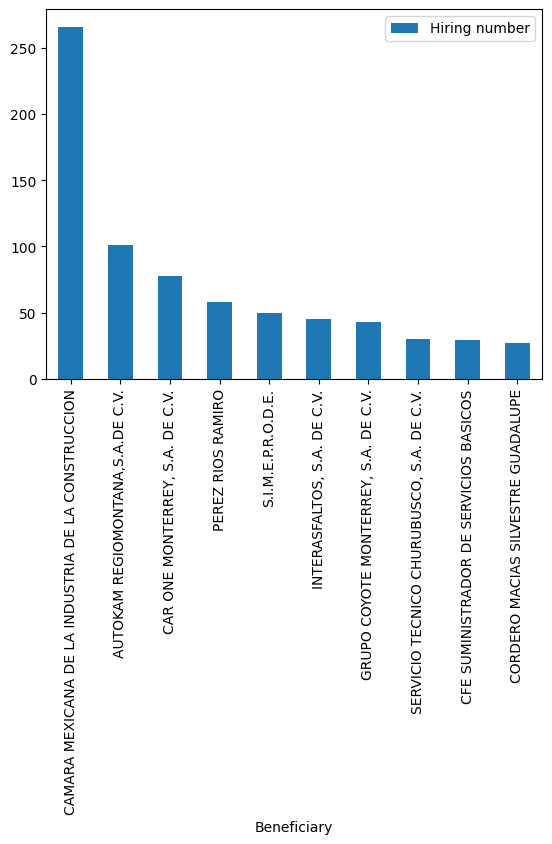

In [ ]:
top_beneficiaries = df_monterrey['BENEFICIARIO'].value_counts()[0:10]
top_beneficiaries = {
    'Beneficiary': top_beneficiaries.index,
    'Hiring number': top_beneficiaries.values
}
top_beneficiaries = pd.DataFrame(top_beneficiaries)
top_beneficiaries.plot(kind='bar', x='Beneficiary', y='Hiring number')

Let us now observe the behavior of the variable 'IMPORTE' with respect to the 95% quantile. We can observe that there is a skewed distribution to the left where there is a large number of atypical beneficiaries in terms of amount of payed services, where they recieve huge amounts of money. On the other hand, we observe that most of the beneficiaries are concentrated in amounts of money much lower than the strongest beneficiaries.

<Axes: xlabel='IMPORTE'>

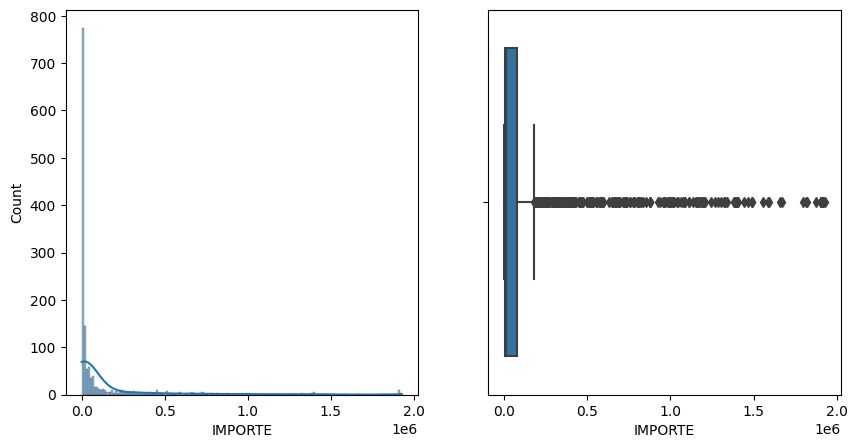

In [ ]:
data_importe = df_monterrey[df_monterrey['IMPORTE'] < df_monterrey['IMPORTE'].quantile(0.95)]['IMPORTE']
data_importe = pd.DataFrame(data_importe, columns=['IMPORTE'])
data = data_importe['IMPORTE']

fig, ax = plt.subplots(1,2,figsize=(10,5))
# Histogram Plot of the 'IMPORTE' variable
sns.histplot(data=data_importe, x='IMPORTE', kde=True, ax = ax[0])
sns.boxplot(data=data_importe, x='IMPORTE')


In [ ]:
condition = df_monterrey['IMPORTE'] < df_monterrey['IMPORTE'].quantile(0.95)
df_monterrey[condition]['BENEFICIARIO'].head()

0    LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.
1    LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.
2    LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.
3    LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.
4    LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.
Name: BENEFICIARIO, dtype: object

From the amount of the amount per beneficiary, we can observe that the entity that ranks in the first five places of payment is the same, being "Llantas y servicios Serna Anahuac, S.A. de C.V." the one that leads in the dataset.

##3.2-Multidimensional variable analysis

From the multivariate analysis corresponding to the relationship between the total amount of a beneficiary and the beneficiary institution, we observed that in the month of December 2020 those entities that scored in the highest total amount were:

1. Municipality of the city of Monterrey.
2. Integration of Advanced Technology Systems.
3. Value Aprendadoras S.A.

<ipython-input-20-3486a5b875a1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_importe_beneficiario = df_monterrey.groupby('BENEFICIARIO').sum()['IMPORTE']


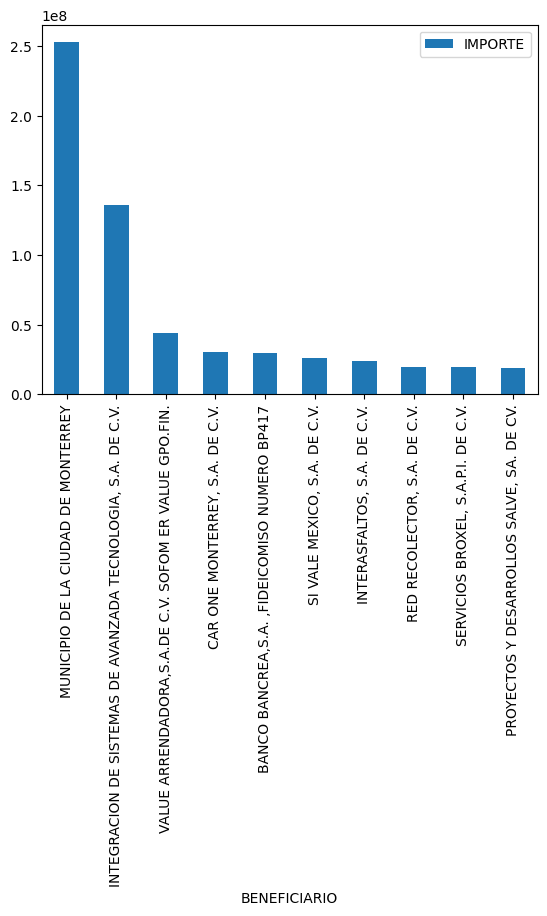

In [ ]:
sum_importe_beneficiario = df_monterrey.groupby('BENEFICIARIO').sum()['IMPORTE']

sum_importe_beneficiario.reset_index().sort_values(by='IMPORTE', ascending=False).iloc[0:10].plot(kind='bar', x='BENEFICIARIO', y='IMPORTE')
plt.show()

If we organize by average payment made to all beneficiaries, according to the category in which the payment took place, the type of expenditure that beneficiaries recieved the most was in 'miscellaneous expenses', followed by 'contractors', 'professional services', 'communication' and finally the lowest investment was in 'personal services'.

<ipython-input-21-145432dea8bb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_importe_type = df_monterrey.groupby('SHEET').mean()['IMPORTE']


<Axes: xlabel='SHEET'>

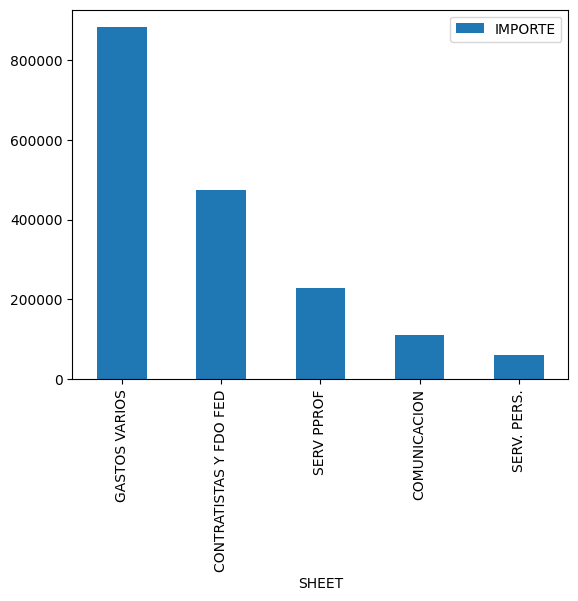

In [ ]:
mean_importe_type = df_monterrey.groupby('SHEET').mean()['IMPORTE']
mean_importe_type.reset_index().sort_values(by='IMPORTE', ascending=False).iloc[0:10].plot(kind='bar', x='SHEET', y='IMPORTE')

In [ ]:
mean_importe_type.reset_index().sort_values(by='IMPORTE', ascending=False).iloc[0:5]

,SHEET,IMPORTE
2,GASTOS VARIOS,881659.731797
1,CONTRATISTAS Y FDO FED,474566.765787
3,SERV PPROF,229592.166667
0,COMUNICACION,109705.343662
4,SERV. PERS.,59623.405217


We proceed to visualize as a time series, the total amount of payments made per day for the month of December.

In [ ]:
sum_importe_fecha = df_monterrey.groupby('FECHA').sum()["IMPORTE"]
sum_importe_fecha

<ipython-input-23-49be6c9c7fea>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sum_importe_fecha = df_monterrey.groupby('FECHA').sum()["IMPORTE"]


FECHA
2020-12-01    2.453181e+04
2020-12-02    3.000000e+04
2020-12-03    1.313241e+05
2020-12-04    7.432247e+07
2020-12-07    1.815018e+06
2020-12-08    1.519824e+08
2020-12-09    4.659596e+05
2020-12-10    1.207010e+06
2020-12-11    1.127524e+08
2020-12-14    3.692338e+05
2020-12-15    1.826510e+04
2020-12-16    2.504067e+06
2020-12-17    1.735205e+08
2020-12-18    1.568875e+08
2020-12-21    9.441760e+05
2020-12-22    6.814845e+07
2020-12-23    3.328571e+07
2020-12-28    1.204764e+08
2020-12-29    2.050000e+05
2020-12-30    6.435889e+07
2020-12-31    1.080281e+06
Name: IMPORTE, dtype: float64

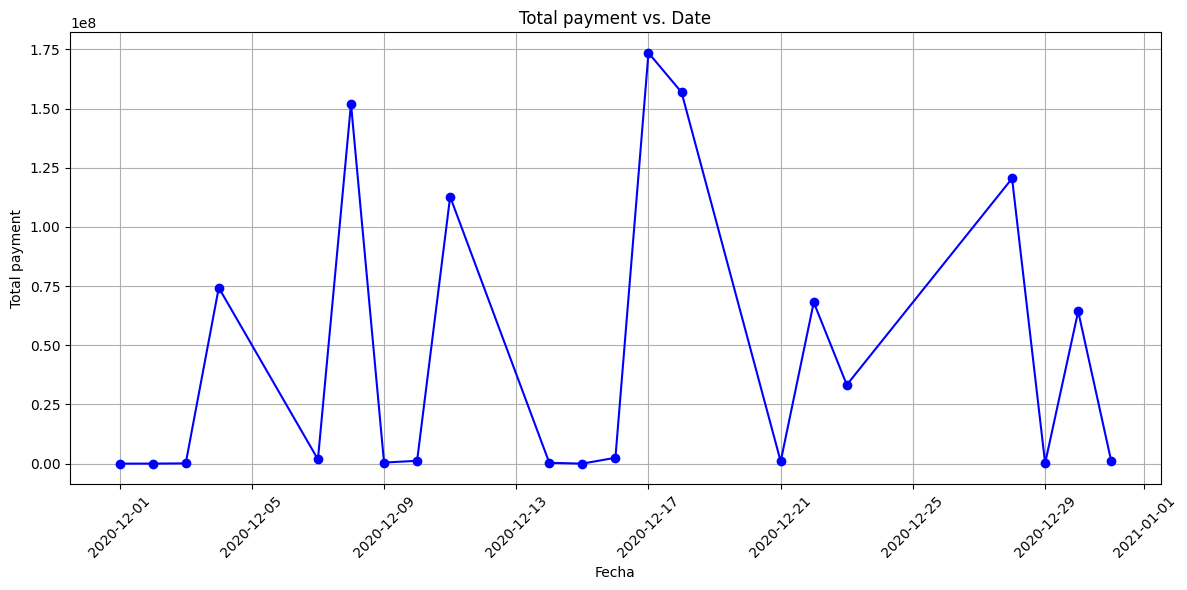

In [ ]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(sum_importe_fecha.index, sum_importe_fecha.values, marker='o', linestyle='-', color='b')
plt.xlabel('Fecha')
plt.ylabel('Total payment')
plt.title('Total payment vs. Date')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust plot layout for better spacing
plt.show()

Now, we generate a pivot table whose columns correspond to the type of payments and whose rows correspond to the beneficiary, being each entry the total value of the amount payed to a beneficiary with respect to a type of expense in the month of December.

Next, we extract the top ten beneficiaries according to their total amount of incomes. With these two informations we can plot the amount incomes per categoty for each of the best beneficieries.

<ipython-input-25-9ffe85130550>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  compras_beneficiario = df_monterrey.groupby(['BENEFICIARIO', 'SHEET']).sum()['IMPORTE'].sort_values().unstack('SHEET')


<Axes: xlabel='BENEFICIARIO'>

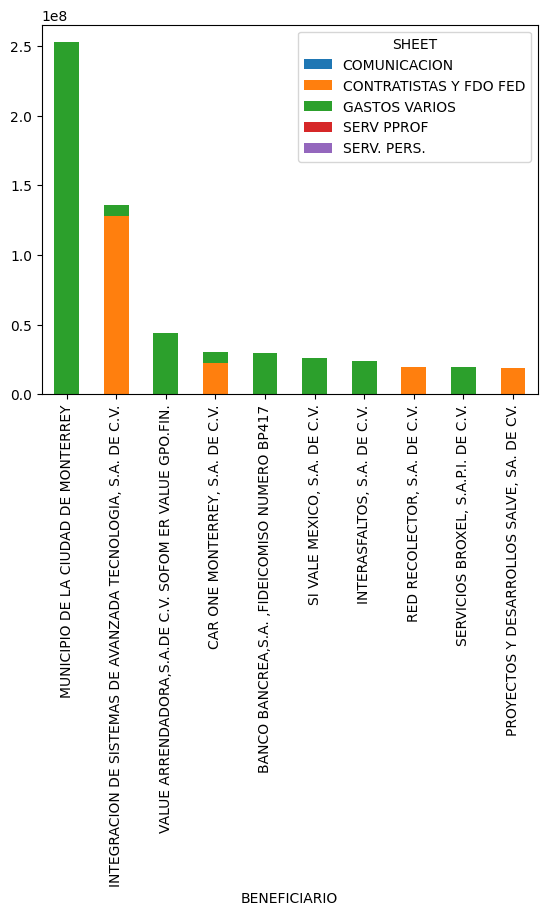

In [ ]:
# Total expense pivot table for each beneficiary
compras_beneficiario = df_monterrey.groupby(['BENEFICIARIO', 'SHEET']).sum()['IMPORTE'].sort_values().unstack('SHEET')

top_beneficiarios = df_monterrey.groupby('BENEFICIARIO')['IMPORTE'].sum().sort_values(ascending=False).index[0:10]

compras_beneficiario.loc[top_beneficiarios].plot.bar(stacked=True)

Surprisingly, the largest vlume of transactions made to beneficiary entities does not correspond always to construction services, but to miscellaneous expenses. Thus, although the type of requieres service that recieved the most money from the municipality of Monterrey was the construction sector in general, the largest beneficiaries of the minicipality´s treasury resived the most income in services to miscellaneous expenses, being contracting services the second place.

##3.3-Text analysis

The following is a brief analysis of the most common topics within the concept of contracting made by the minicipality of Monterrey.

To do this, we will proceed to concatenate all the concept types available in the dataset and generate a string of sentences separated by spaces, containing all the types of contracting carried out. Then we separate each word in the chain of sentences by eliminating the stopwords, to finally perform a word cloud of the words found.

In [ ]:
text_payments = ''
for row in df_monterrey['CONCEPTO']:
  text_payments = text_payments + ' ' + row

In [ ]:
stopwords_list = stopwords.words('spanish') + ['2020', 'cont', 'millar', 'dpp', 'est', 'op', 'ret', 'mty', 'icom']
# We apply a filter to the topics, exluding stopwords
list_words = [x for x in text_payments.strip().lower().split(' ') if x not in stopwords_list and len(x)>4]
text_payments = ' '.join(list_words)

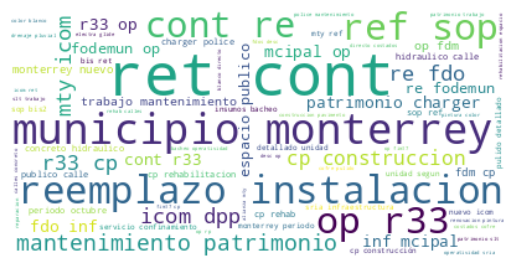

In [ ]:
wc = WordCloud(background_color = 'white')
wc.generate(text_payments)

plt.axis('off')
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

Thus, at first glance, we can see that the most central themes in contracting were precisely related to public works, more specifically to:

1. maintenance of the patrimony.
2. Replacement of facilities.

#4)-Data Enrichement

##4.1-Data expansion

For consistency, we proceed to transform the date variable to a date-time format since it is originally stored in the data set as a string object, then, we use the information contained within this column to add the variables, day, month and year.

In [ ]:
# String date to date time
df_monterrey['FECHA'] = pd.to_datetime(df_monterrey['FECHA'])
df_monterrey['DIA'] = df_monterrey['FECHA'].dt.day
df_monterrey['MES'] = df_monterrey['FECHA'].dt.month
df_monterrey['AÑO'] = df_monterrey['FECHA'].dt.year

##4.2-Data projection

In [ ]:
# Payment amounts per beneficiary
beneficiario_sales = df_monterrey['BENEFICIARIO'].value_counts().to_dict()

# Projected variable
df_monterrey['BENEFICIARIO_SALES'] = df_monterrey['BENEFICIARIO'].apply(lambda x: beneficiario_sales[x])
df_monterrey.head()

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES
0,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS,11,12,2020,13
1,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS,11,12,2020,13
2,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS,11,12,2020,13
3,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS,11,12,2020,13
4,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS,23,12,2020,13


In general, purchases by the Monterrey treasury averaged the following values for each of the municipality's needs.

In [ ]:
sheet_mean_purchases = df_monterrey.groupby('SHEET')['IMPORTE'].mean()
sheet_mean_purchases

SHEET
COMUNICACION              109705.343662
CONTRATISTAS Y FDO FED    474566.765787
GASTOS VARIOS             881659.731797
SERV PPROF                229592.166667
SERV. PERS.                59623.405217
Name: IMPORTE, dtype: float64

Finally, once we have added the date, day, month and year information by row, we add the purchase averages by expense category to the original dataset as an extra column.

In [ ]:
sheet_mean_purchases.to_dict()
df_monterrey['IMPORTE_GASTO_PROMEDIO'] = df_monterrey['SHEET'].apply(lambda x: sheet_mean_purchases[x])
df_monterrey.head()

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO
0,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS,11,12,2020,13,881659.731797
1,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS,11,12,2020,13,881659.731797
2,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS,11,12,2020,13,881659.731797
3,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS,11,12,2020,13,881659.731797
4,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS,23,12,2020,13,881659.731797


##4.3-Complementary information

We then enriched the available data by adding for each beneficiary a binary variable that specifies whether or not the beneficiary has a LinkedIn website.

In [ ]:
# Data import
path = '/content/drive/MyDrive/Colab Notebooks/2)-Machine Learning/1)-Platzy Career (Machine Learning)/10)-Data Science Projects/2)-Treasury_Monterrey_12_DECI_2020/linkedin_mty.csv'
linkedin_mty = pd.read_csv(path)

# Data processing
has_site = {}
for i, ele in linkedin_mty.fillna(True).iterrows():
  has_site[ele['query']] = True if ele['error'] == True else False

In [ ]:
df_monterrey['HAS_LINKEDIN_SITE'] = df_monterrey['BENEFICIARIO'].apply(lambda x: has_site[x.replace('  ', ' ')])
df_monterrey.head()

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE
0,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS AF8458-158008-3972,OT. 20204373,REEMPLAZO E INSTALACION DE AMORTIGUADORES (DEL...,TR,1019110.0,2020-12-11,14911.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True
1,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6916-158008-4041,OT. 20204425,REEMPLAZO E INSTALACION DE OCHO BIRLOS Y NUEVE...,TR,1019110.0,2020-12-11,2528.80,GASTOS VARIOS,11,12,2020,13,881659.731797,True
2,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF6917-158008-3975,OT. 20204376,REEMPLAZO DE DOS RINES (17). PATRIMONIO 80383...,TR,1019110.0,2020-12-11,8500.02,GASTOS VARIOS,11,12,2020,13,881659.731797,True
3,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7004-158008-3971,OT. 20204374,REEMPLAZO DE DOS RINES (14). PATRIMONIO 8007...,TR,1019110.0,2020-12-11,2400.01,GASTOS VARIOS,11,12,2020,13,881659.731797,True
4,"LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.",LSS841015DV3,LLS PF7137-158008-4554,OT. 20205130,REEMPLAZO E INSTALACION DE RIN 14. PATRIMONIO ...,TR,299001496.0,2020-12-23,1537.00,GASTOS VARIOS,23,12,2020,13,881659.731797,True


In [ ]:
df_monterrey['HAS_LINKEDIN_SITE']

0     True
1     True
2     True
3     True
4     True
      ... 
42    True
43    True
44    True
45    True
46    True
Name: HAS_LINKEDIN_SITE, Length: 1540, dtype: bool

In [ ]:
df_monterrey['HAS_LINKEDIN_SITE'].value_counts()

True     1392
False     148
Name: HAS_LINKEDIN_SITE, dtype: int64

#5)-Modeling and Machine Learning

In order to model the patterns in our data, we need to perform processing before using them as input to our Machine Learning algorithm. To do this, we first make sure that the categorical data is complete by filling in those empty cells with the mode of each column. If the data is numeric, we fill in the empty spaces with the average of the data.
Finally, for categorical data, we number the data by category codes.

##5.1-Supervised learning model

Next, we will run a supervised regression model to predict the amount variable, making use of the Random Forest Regressor method in conjunction with an automatic parameter optimization using the grid search method, which executes by default a cross validation.

In [ ]:
data = df_monterrey.copy()
types = list([str(Type) for Type in data.dtypes])

for i, column in enumerate(types):
  if column == 'object':
    # filling emplty cels with column mode
    data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
    # data numerization
    data[data.columns[i]] = data[data.columns[i]].astype('category').cat.codes
  elif column == 'bool':
    data[data.columns[i]] = data[data.columns[i]].astype(int)
  else:
    # fillinf empty cells
    data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

# We wliminate the column 'FECHA'
cat = list(data.columns)
cat = cat[:6] + cat[8:]
data = data[cat]

data.head()

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE
0,161,167,1388,130,780,1,14911.80,2,11,12,2020,13,881659.731797,1
1,161,167,1389,135,845,1,2528.80,2,11,12,2020,13,881659.731797,1
2,161,167,1390,132,759,1,8500.02,2,11,12,2020,13,881659.731797,1
3,161,167,1391,131,757,1,2400.01,2,11,12,2020,13,881659.731797,1
4,161,167,1392,417,859,1,1537.00,2,23,12,2020,13,881659.731797,1


In [ ]:
X = data.copy()
X = X.drop(['IMPORTE'], axis=1)
y = data['IMPORTE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=16)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

params = {
    'n_estimators':[10,100,1000],
    'max_depth':[4,5,6,7,8,9,10]
}

clf = RandomForestRegressor()
grid_reg = GridSearchCV(clf, params, cv = 5)
grid_reg.fit(X_train, y_train.ravel())

performance = grid_reg.best_score_
best_model = grid_reg.best_estimator_

print('Random forest regressor best model: ', best_model )
print('Random forest regressor performance: ', performance)

Random forest regressor best model:  RandomForestRegressor(max_depth=5, n_estimators=10)
Random forest regressor performance:  -1.0165524766307183


In [ ]:
clf = RandomForestRegressor(n_estimators=1000, max_depth=9)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
performance = r2_score(y_test, prediction)

print('Random forest regressor best model: ', best_model )
print('Random forest regressor performance: ', np.abs(performance))

Random forest regressor best model:  RandomForestRegressor(max_depth=5, n_estimators=10)
Random forest regressor performance:  0.22023141779794686


##5.2-Unsupervised learning model

Once we have made an effort to obtain a model that allows us to predict the value of the amount according to the characteristics of the municipality's needs, we proceed to apply a non-supervised learning model in order to draw conclusions about the types of business that have been carried out. More specifically, we will employ basic natural language processing tools in conjunction with clustering algorithms to group relevant topics.

To begin with, we will process the texts referring to the names of the beneficiaries, since this will give us an idea of the type of business that each one manages.

In [ ]:
# beneficiary processed text
process_business = [preprocess(x) for x in list(df_monterrey['BENEFICIARIO'].unique())]

We set a filter condition where if the word appears only once in the text set, it will not be included in the dictionary, while if the word appears in more than 50% of the text set, it will be removed from the dictionary. This is done to ensure that words that are too frequent or infrequent do not generate bias in the clustering modeling.

In [ ]:
# Beneficiary dictionary
dictionary = gensim.corpora.Dictionary(process_business)
# Frequency filter
dictionary.filter_extremes(no_below=1, no_above=0.5)
# Dictionary numerization
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]
bow_corpus[0:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1)],
 [(7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1)],
 [(17, 1), (18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1)],
 [(24, 1)],
 [(5, 1), (25, 1), (26, 1)]]

We generated a word clustering model that allows us to group the names of the beneficiaries and gives us a notion of how the services are distributed.

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [ ]:
for idx, type_business in lda_model.print_topics(-1):
  print('Topic: {} - Words: {}'.format(idx, type_business))

Topic: 0 - Words: 0.046*"MARIA" + 0.025*"GARCIA" + 0.025*"GRUPO" + 0.017*"SEGUROS" + 0.013*"GARZA" + 0.013*"TREVIÑO" + 0.013*"ORTIZ" + 0.013*"SALAZAR" + 0.013*"FINANCIERO" + 0.009*"GOMEZ"
Topic: 1 - Words: 0.020*"NUEVO" + 0.015*"GUERRERO" + 0.015*"LEON," + 0.010*"HERNANDEZ" + 0.010*"CONSTRUCCIONES" + 0.010*"URBANIZACIONES" + 0.010*"VILLARREAL" + 0.010*"JAVIER" + 0.010*"NATALIA" + 0.005*"UNIVERSIDAD"
Topic: 2 - Words: 0.017*"GONZALEZ" + 0.013*"GARZA" + 0.013*"ALBERTO" + 0.009*"MEXICO," + 0.009*"SANCHEZ" + 0.009*"CARLOS" + 0.009*"EDGAR" + 0.009*"INSTITUTO" + 0.009*"SEGURIDAD" + 0.009*"EDIFICACIONES"
Topic: 3 - Words: 0.020*"SERVICIOS" + 0.020*"DESARROLLOS" + 0.015*"MONTERREY," + 0.015*"CONSTRUCCION" + 0.010*"GUADALUPE" + 0.010*"GONZALEZ" + 0.010*"INMOBILIARIA" + 0.010*"HUINALA," + 0.010*"MARIA" + 0.010*"ALEJANDRO"
Topic: 4 - Words: 0.020*"RODRIGUEZ" + 0.012*"CONSTRUCCIONES" + 0.012*"SERVICIOS" + 0.012*"BANCO" + 0.012*"INFRAESTRUCTURA" + 0.008*"MARCELO" + 0.008*"SOFOM" + 0.008*"DESARROLLO

In [ ]:
def get_max_topic(index):
  results = lda_model[bow_corpus[index]]
  return max(lda_model[results], key=lambda x:x[1])[0]

In [ ]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(df_monterrey['BENEFICIARIO'].unique()))}
business_cluster

{'LLANTAS Y SERVICIOS SERNA ANAHUAC,S.A. DE C.V.': 2,
 'GH MAQUINARIA Y EQUIPO, S.A.DE C.V.': 5,
 'PLOMIFERRETERA EL TORNILLO, S.A. DE C.V.': 2,
 'EQUIPOS Y ACCESORIOS CANTU, S.A. DE C.V.': 2,
 'PRAXAIR MEXICO S. DE R.L. DE C.V.': 5,
 'COMERCIALIZADORA HNOS.ALVAREZ FLORES,S.A.DE C.V.': 5,
 'DISTRIBUIDORA DE FRUTAS Y LEGUMBRES LA HORTALIZA,S.A.DE C.V.': 5,
 'NUÑEZ LOPEZ VIRGINIA': 5,
 'S.I.M.E.P.R.O.D.E.': 2,
 'TRACTORES Y MAQUINARIA REAL, S.A. DE C.V.': 5,
 'TELEFONOS DE MEXICO,S.A.B DE C.V.': 2,
 'MERCANTIL DISTRIBUIDORA, S.A. DE C.V.': 3,
 'GRANA,S.A.': 5,
 'CLUB INTERNACIONAL DE MONTERREY,A.C.': 5,
 'EMPACADORA Y DISTR.DE CARNES FINAS SAN JUAN,S.A.DE C.V.': 5,
 'VIVERO EL ESCORIAL, S.A. DE C.V.': 3,
 'CAR ONE AMERICANA,S.A.DE C.V.': 2,
 'MANTENIMIENTO ELECTRICO DE POTENCIA,S.A.DE C.V.': 5,
 'AUTOKAM REGIOMONTANA,S.A.DE C.V.': 2,
 'CLIMEEZ DEL NORTE,S.A.DE C.V.': 5,
 'VALUE ARRENDADORA,S.A.DE C.V. SOFOM ER VALUE GPO.FIN.': 5,
 'SEGUROS AFIRME, S.A. DE C.V. AFIRME GRUPO FINANCIERO': 2

In [ ]:
df_monterrey['CLUSTER_NAME'] = df_monterrey['BENEFICIARIO'].apply(lambda x: business_cluster[x])

In [ ]:
df_monterrey['CLUSTER_NAME'].value_counts()

2    663
3    447
5    430
Name: CLUSTER_NAME, dtype: int64

<Axes: xlabel='CLUSTER_NAME'>

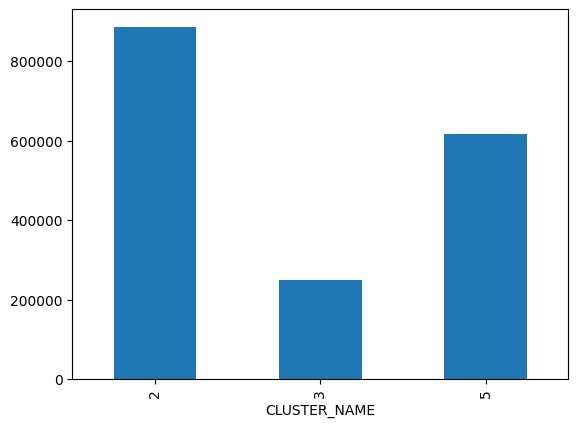

In [ ]:
df_monterrey.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()

From this analysis, we can see that the three most relevant word clusters are 2, 3 and 5, which respectively are mostly composed of services of:

1. construction -> 2
2. Services -> 3
3. Construction and real estate -> 5

We also see that the cluster with the highest average amount is cluster two, which refers to the construction sector.

##5.3-Anomaly detection

For the anomaly detection process, we will use the Gaussian anomaly method, where we will look for data that are in the tails of the normal distribution as a crude approximation to a first guess at how our data are organized.

In [ ]:
params = norm.fit(df_monterrey['IMPORTE'])
print('Mean: {} - Standard Dev: {}'.format(params[0], params[1]))

Mean: 626317.9473441559 - Standard Dev: 4665396.47441213


Based on the Gaussian parameters, we generate the probability of obtaining an amount value for each transaction made to a beneficiary.

<Axes: >

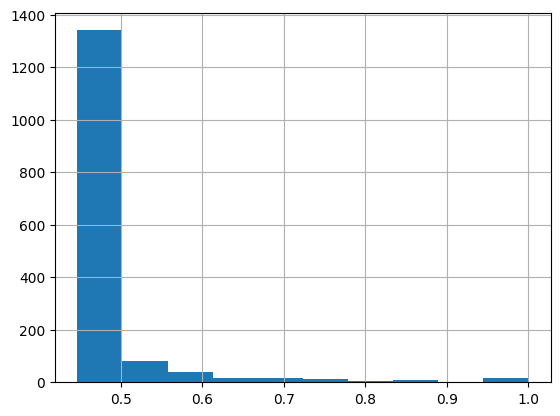

In [ ]:
df_monterrey['PROB_TOTAL'] = [norm(params[0], params[1]).cdf(x) for x in df_monterrey['IMPORTE']]
df_monterrey['PROB_TOTAL'].hist()


As we can observe, the cumulative Gaussian probability of obtaining an amount value is mostly concentrated at 0.5 for amount values close to 1400 Mexican pesos, thus, we will focus on the study of the tail of the distribution where the outliers are found.

In [ ]:
outliers = df_monterrey[df_monterrey['PROB_TOTAL'] > 0.95]
outliers.head()

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE,CLUSTER_NAME,PROB_TOTAL
336,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9000000.00,GASTOS VARIOS,30,12,2020,2,881659.731797,True,3,0.963661
415,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9071255.84,GASTOS VARIOS,11,12,2020,2,881659.731797,True,5,0.964862
416,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9078244.84,GASTOS VARIOS,18,12,2020,2,881659.731797,True,5,0.964978
421,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,30000000.00,GASTOS VARIOS,11,12,2020,1,881659.731797,False,5,1.000000
438,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,73864368.92,GASTOS VARIOS,17,12,2020,16,881659.731797,True,2,1.000000


<Axes: >

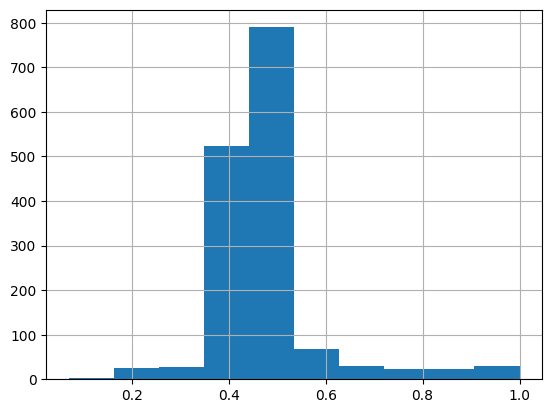

In [ ]:
# Gaussian model for import variable by sheet
gaussian_model_sheet = {}

for sheet in list(df_monterrey['SHEET'].unique()):
  sheet_monterrey = df_monterrey[df_monterrey['SHEET'] == sheet]
  params = norm.fit(sheet_monterrey['IMPORTE'])
  gaussian_model_sheet[sheet] = norm(params[0], params[1])


sheet_prob = []

for i, row in df_monterrey.iterrows():
  sheet_prob.append(gaussian_model_sheet[row['SHEET']].cdf(row['IMPORTE']))

df_monterrey['PROB_SHEET'] = sheet_prob

df_monterrey['PROB_SHEET'].hist()

In [ ]:
df_monterrey[df_monterrey['PROB_SHEET'] > 0.95]

,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,DIA,MES,AÑO,BENEFICIARIO_SALES,IMPORTE_GASTO_PROMEDIO,HAS_LINKEDIN_SITE,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET
336,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,30,12,2020,2,881659.731797,True,3,0.963661,0.953737
415,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,11,12,2020,2,881659.731797,True,5,0.964862,0.955151
416,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,18,12,2020,2,881659.731797,True,5,0.964978,0.955287
421,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,11,12,2020,1,881659.731797,False,5,1.000000,1.000000
438,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,2,1.000000,1.000000
439,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,2,1.000000,1.000000
440,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,17,12,2020,16,881659.731797,True,2,0.999967,0.999929
441,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,2,1.000000,1.000000
443,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,2,1.000000,1.000000
445,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,28,12,2020,16,881659.731797,True,2,0.996833,0.995149
